## Criando uma engine de busca de imagens baseado em texturas
***

Ao contrário das características de textura de Haralick que calculam uma representação global de textura com base na matriz de Co-ocorrência de nível de cinza, as LBPs, em vez disso, calculam uma representação local da textura. Essa representação local é realizada comparando cada pixel com sua vizinhança circundante de valores de pixel.

Em geral, os LBPs são substancialmente mais poderosos do que os recursos de textura Haralick; No entanto, a capacidade discriminativa aumentada vem em um custo talvez computacionalmente proibitivo e tamanho de vetor de recurso potencialmente explosivo, dependendo da aplicação (e do tipo de método LBP usado).

Talvez mais notavelmente, os LBPs foram utilizados com sucesso para realizar o reconhecimento robusto do rosto, como demonstrado por Ahonen et al., em seu documento Reconhecimento facial com padrões binários locais.

Podemos usar qualquer tipo de características, além da textura.

***

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from imutils import paths
from skimage import feature
import cv2


def show(img, title=""):
    """
    Redimensionar a imagem e mostrar no codigo.
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.title(title, fontdict={"fontsize": 100})
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [2]:
class LocalBinaryPatterns(object):
    """
    Engine de busca
    """

    def __init__(self, numPoints, radius):
        """
        Construtor que armazena o número de pontos e raio
        """

        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        """
        Cria o histograma de padrões binários locais.
        """

        # Computa a representação do Local Binary Patterns da imagem e depois usa a representação LBP 
        # para construir o histograma de padrões
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")

        # A variável lbp retornada pela função local_binary_pattern não é diretamente utilizável como
        # vetor de recurso. Em vez disso, lbp é uma matriz 2D com a mesma largura e altura que a nossa
        # imagem de entrada - cada um dos valores dentro de lbp varia de [0, 25], um valor para cada um
        # dos 25 possíveis protótipos invariantes de LBP, juntamente com uma dimensão extra para todos
        # os padrões que não são uniformes, produzindo um total de 26 valores únicos possíveis.
        # Assim, para construir o vetor de recurso real, precisamos fazer uma chamada para np.histogram, 
        # que conta o número de vezes que cada um dos protótipos LBP aparece. 
        # O histograma retornado é 26-d, uma contagem de número inteiro para cada um dos protótipos. 
        (hist, _) = np.histogram(lbp.ravel(), bins=range(0, self.numPoints + 3), range=(0, self.numPoints + 2))

        # Normaliza o histograma
        # Em seguida, tomamos esse histograma e normalizamos de tal forma que a soma seja 1, e depois
        # devolvemos à nossa função de chamada.
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # Retorna o histograma de padrões binários locais
        return hist

In [3]:
# Inicializa o descritor de padrões binários locais e inicializa o dicionário de índice onde o nome do arquivo 
# da imagem é a chave e os recursos são o valor
desc = LocalBinaryPatterns(24, 8)
index = {}

In [4]:
# Loop pelas imagens de camisas
for imagePath in paths.list_images("imagens/dataset03/shirts"):
    # Carrega a imagem, converte em escala de cinza e descreve a image
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)

    # Atualiza o índice do dicionário
    filename = imagePath[imagePath.rfind("/") + 1:]
    index[filename] = hist

In [5]:
# Carrega a imagem de consulta e extrai os padrões binários locais dele
query = cv2.imread("imagens/dataset03/queries/query_01.jpg")
queryFeatures = desc.describe(cv2.cvtColor(query, cv2.COLOR_BGR2GRAY))

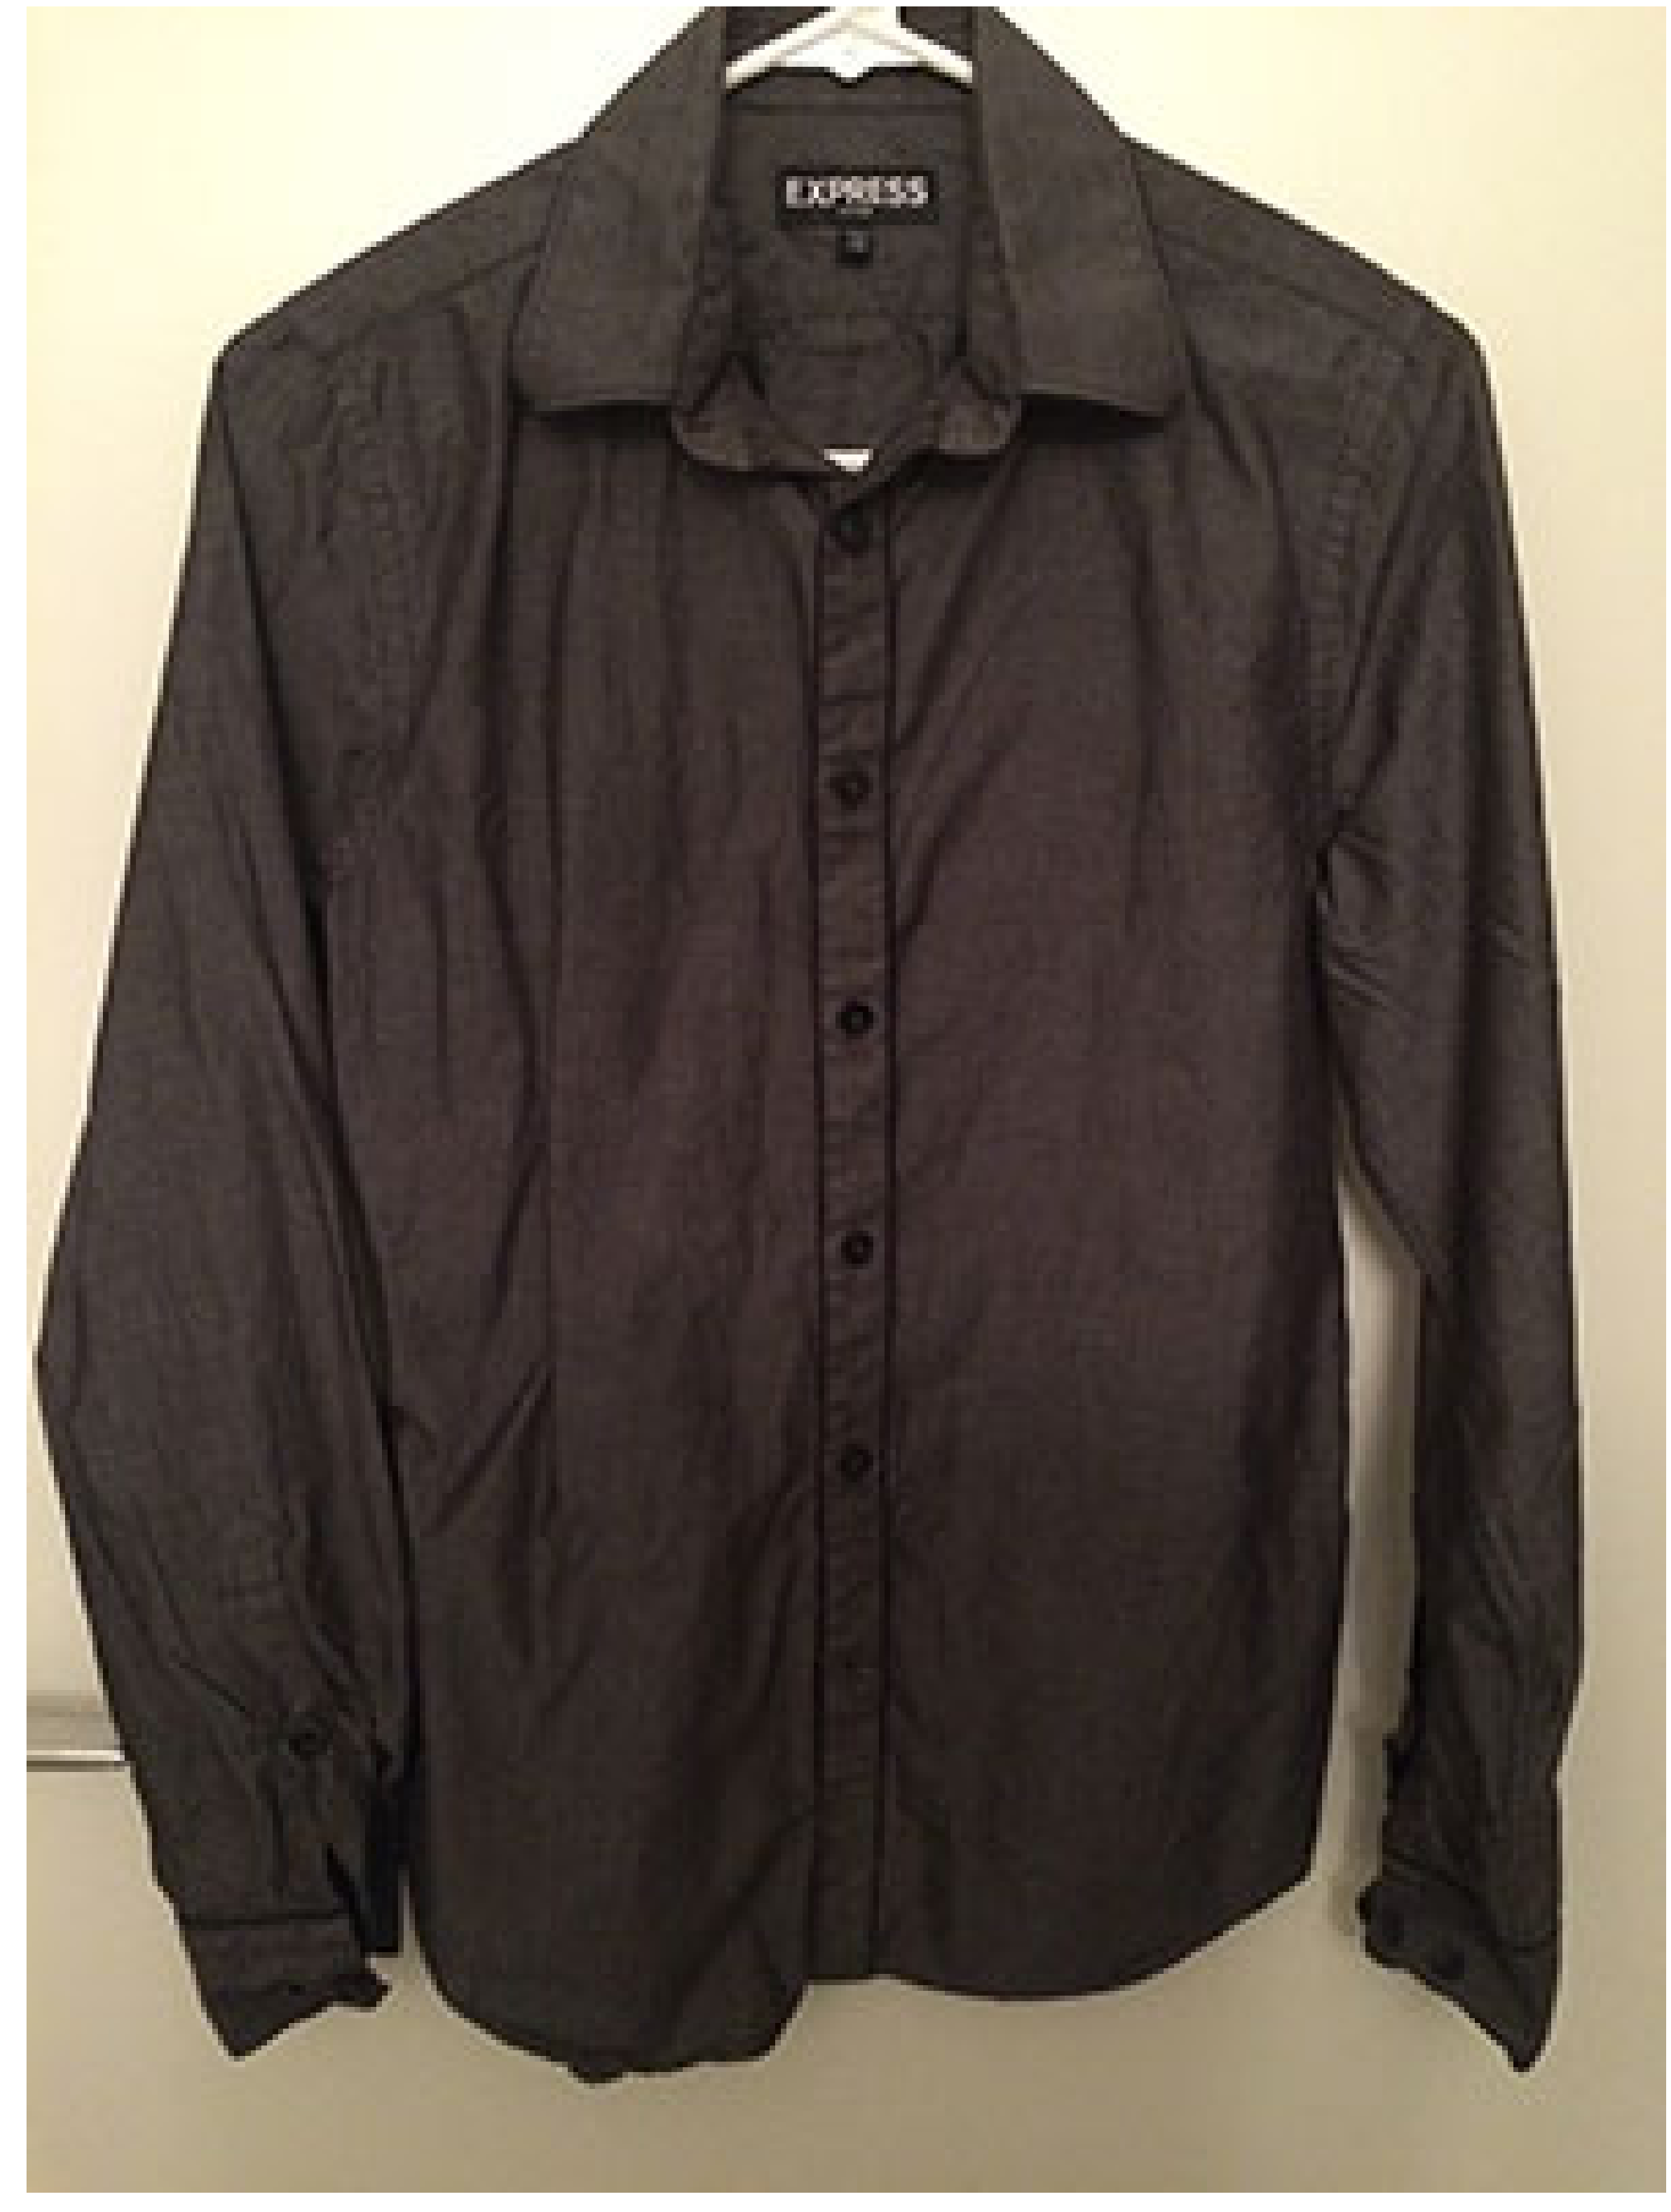

In [6]:
# Mostra a imagem da consulta e inicializa o dicionário de resultados
show(query)
results = {}

In [7]:
# Loop pelo índice
for (k, features) in index.items():
    # Calcula a distância do qui-quadrado entre os recursos atuais e os recursos da consulta, e
    # depois atualiza o dicionário de resultados. A "pesquisa" real ocorre aqui, onde roteamos os
    # vetores de recursos em nosso conjunto de dados, comparamos com os recursos da consulta usando
    # a distância qui-quadrado e, em seguida, atualizamos nosso dicionário de resultados. A distância
    # qui-quadrado é uma excelente escolha para este problema, pois é adequado para comparar histogramas.
    d = 0.5 * np.sum(((features - queryFeatures) ** 2) / (features + queryFeatures + 1e-10))
    results[k] = d

In [8]:
# Organiza os resultados
results = sorted([(v, k) for (k, v) in results.items()])[:3]

#1. shirt_02.jpg: 0.0073


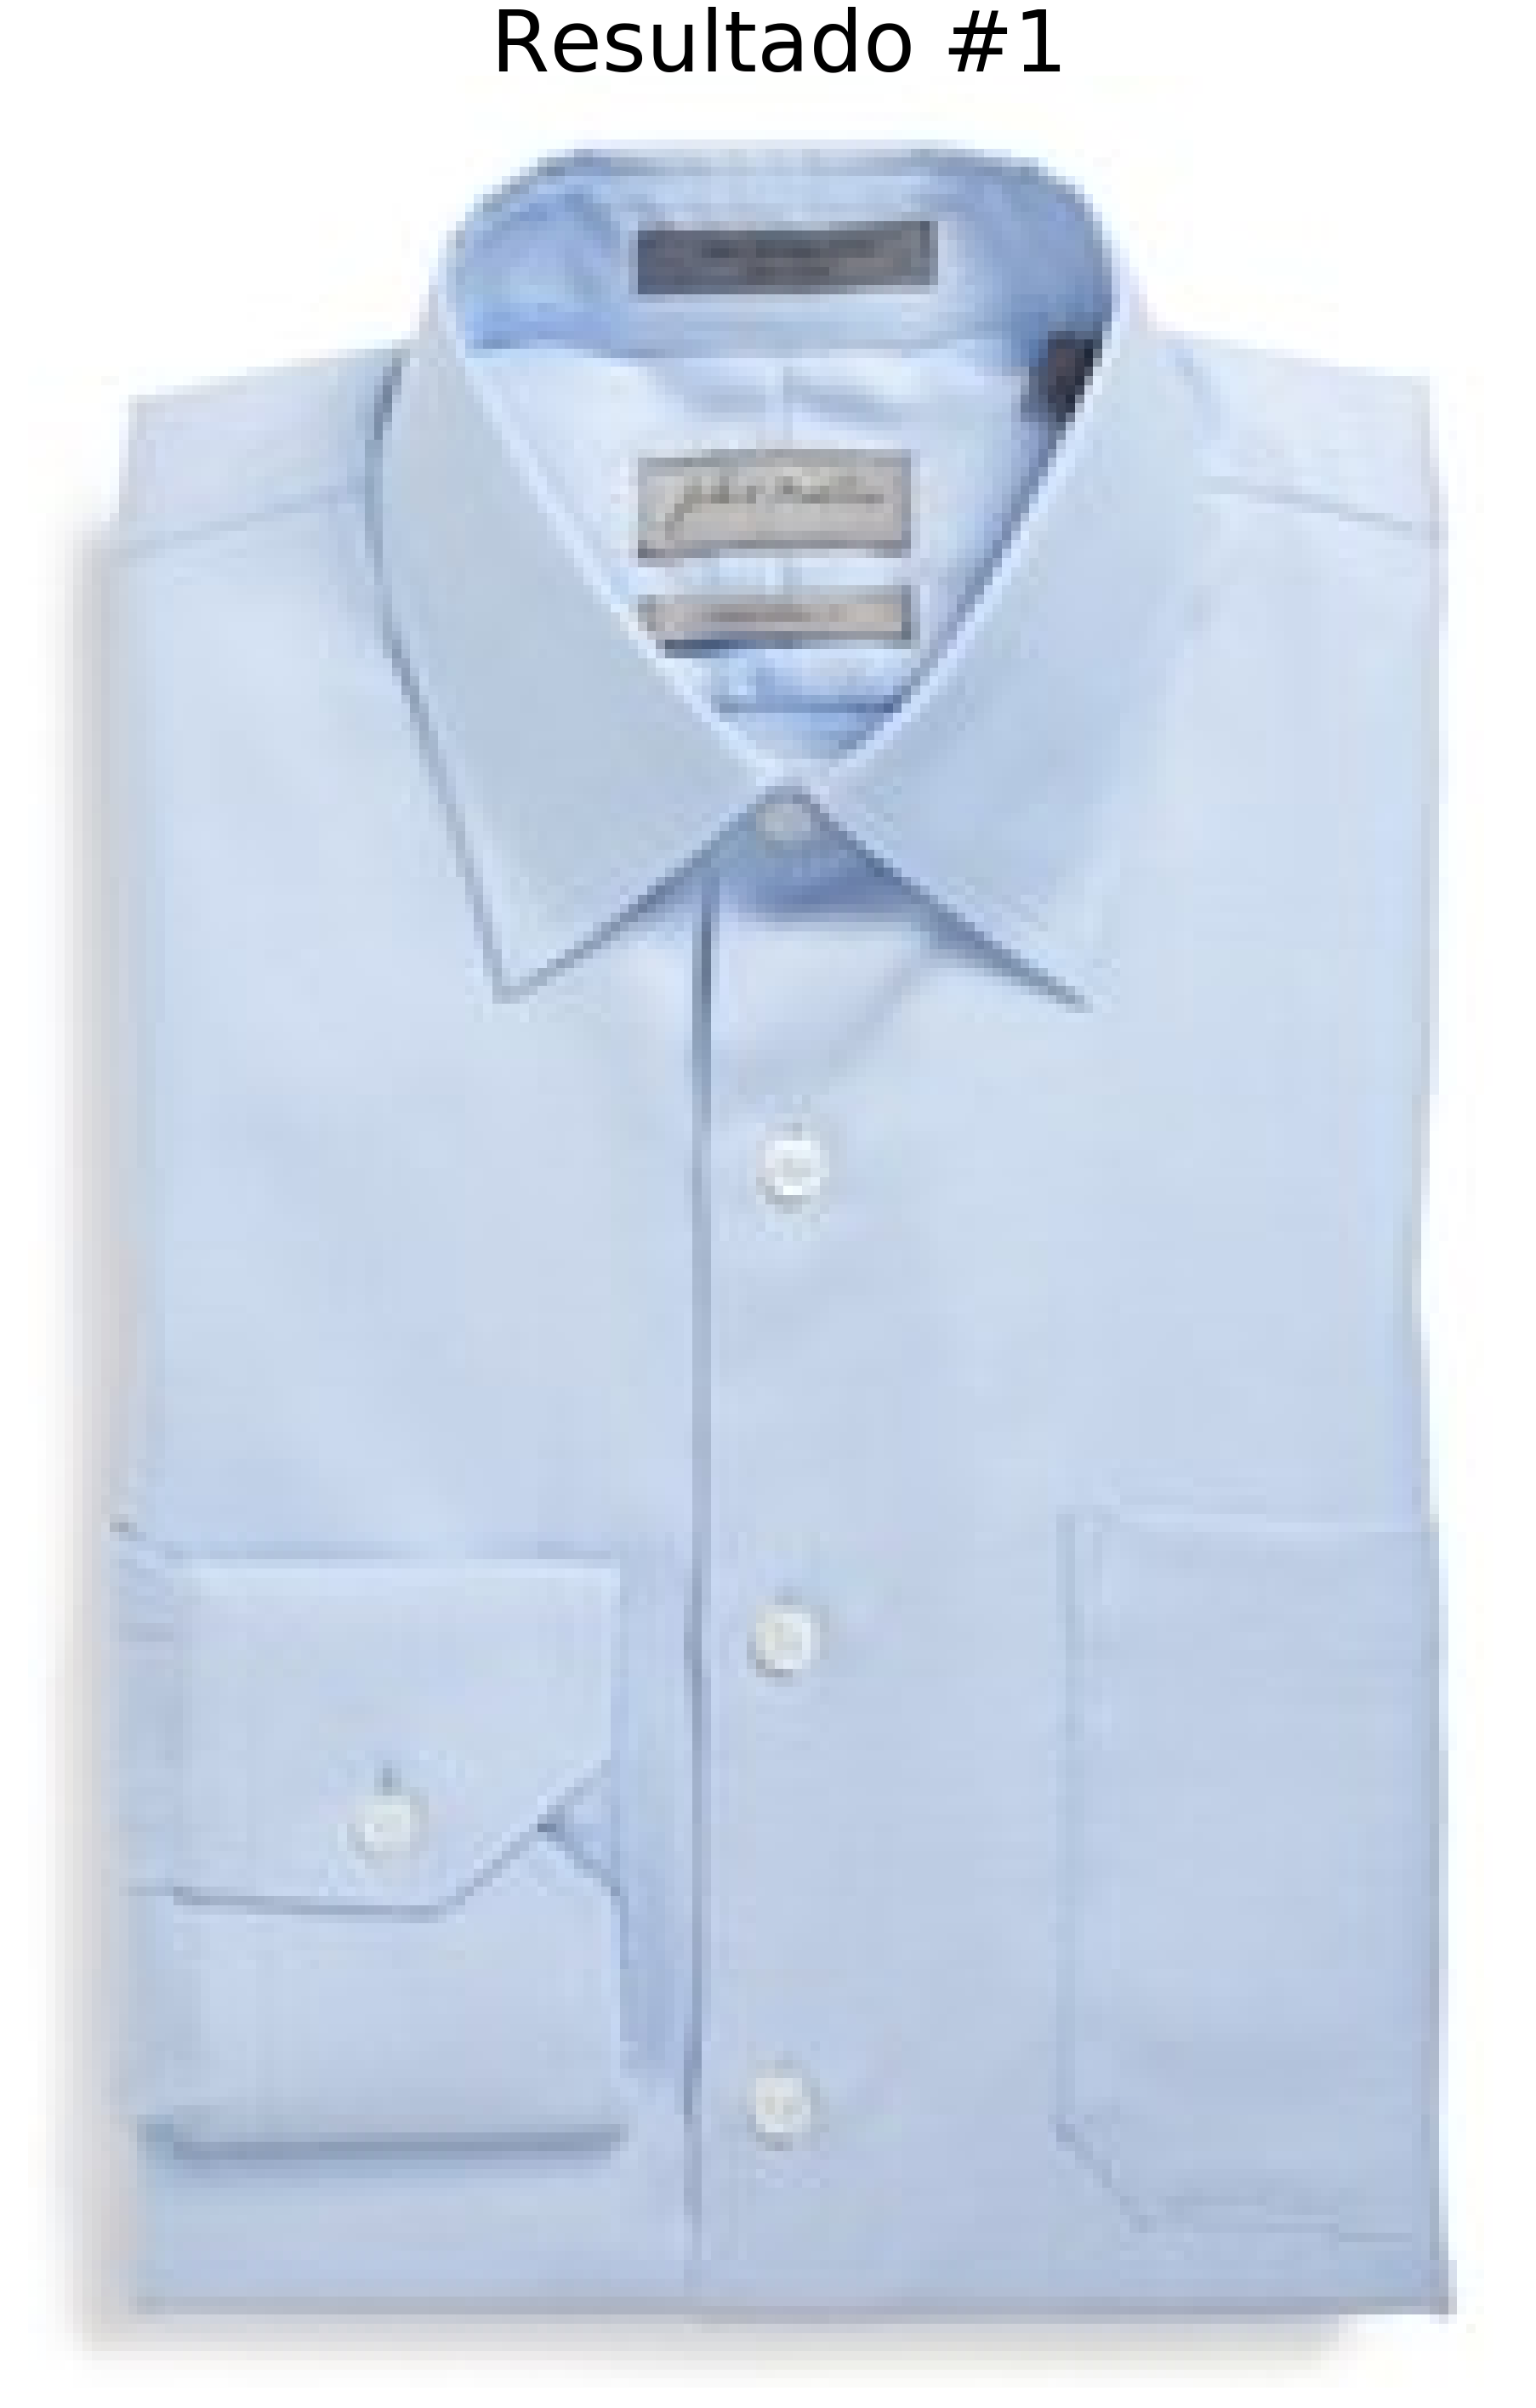

#2. shirt_03.jpg: 0.0119


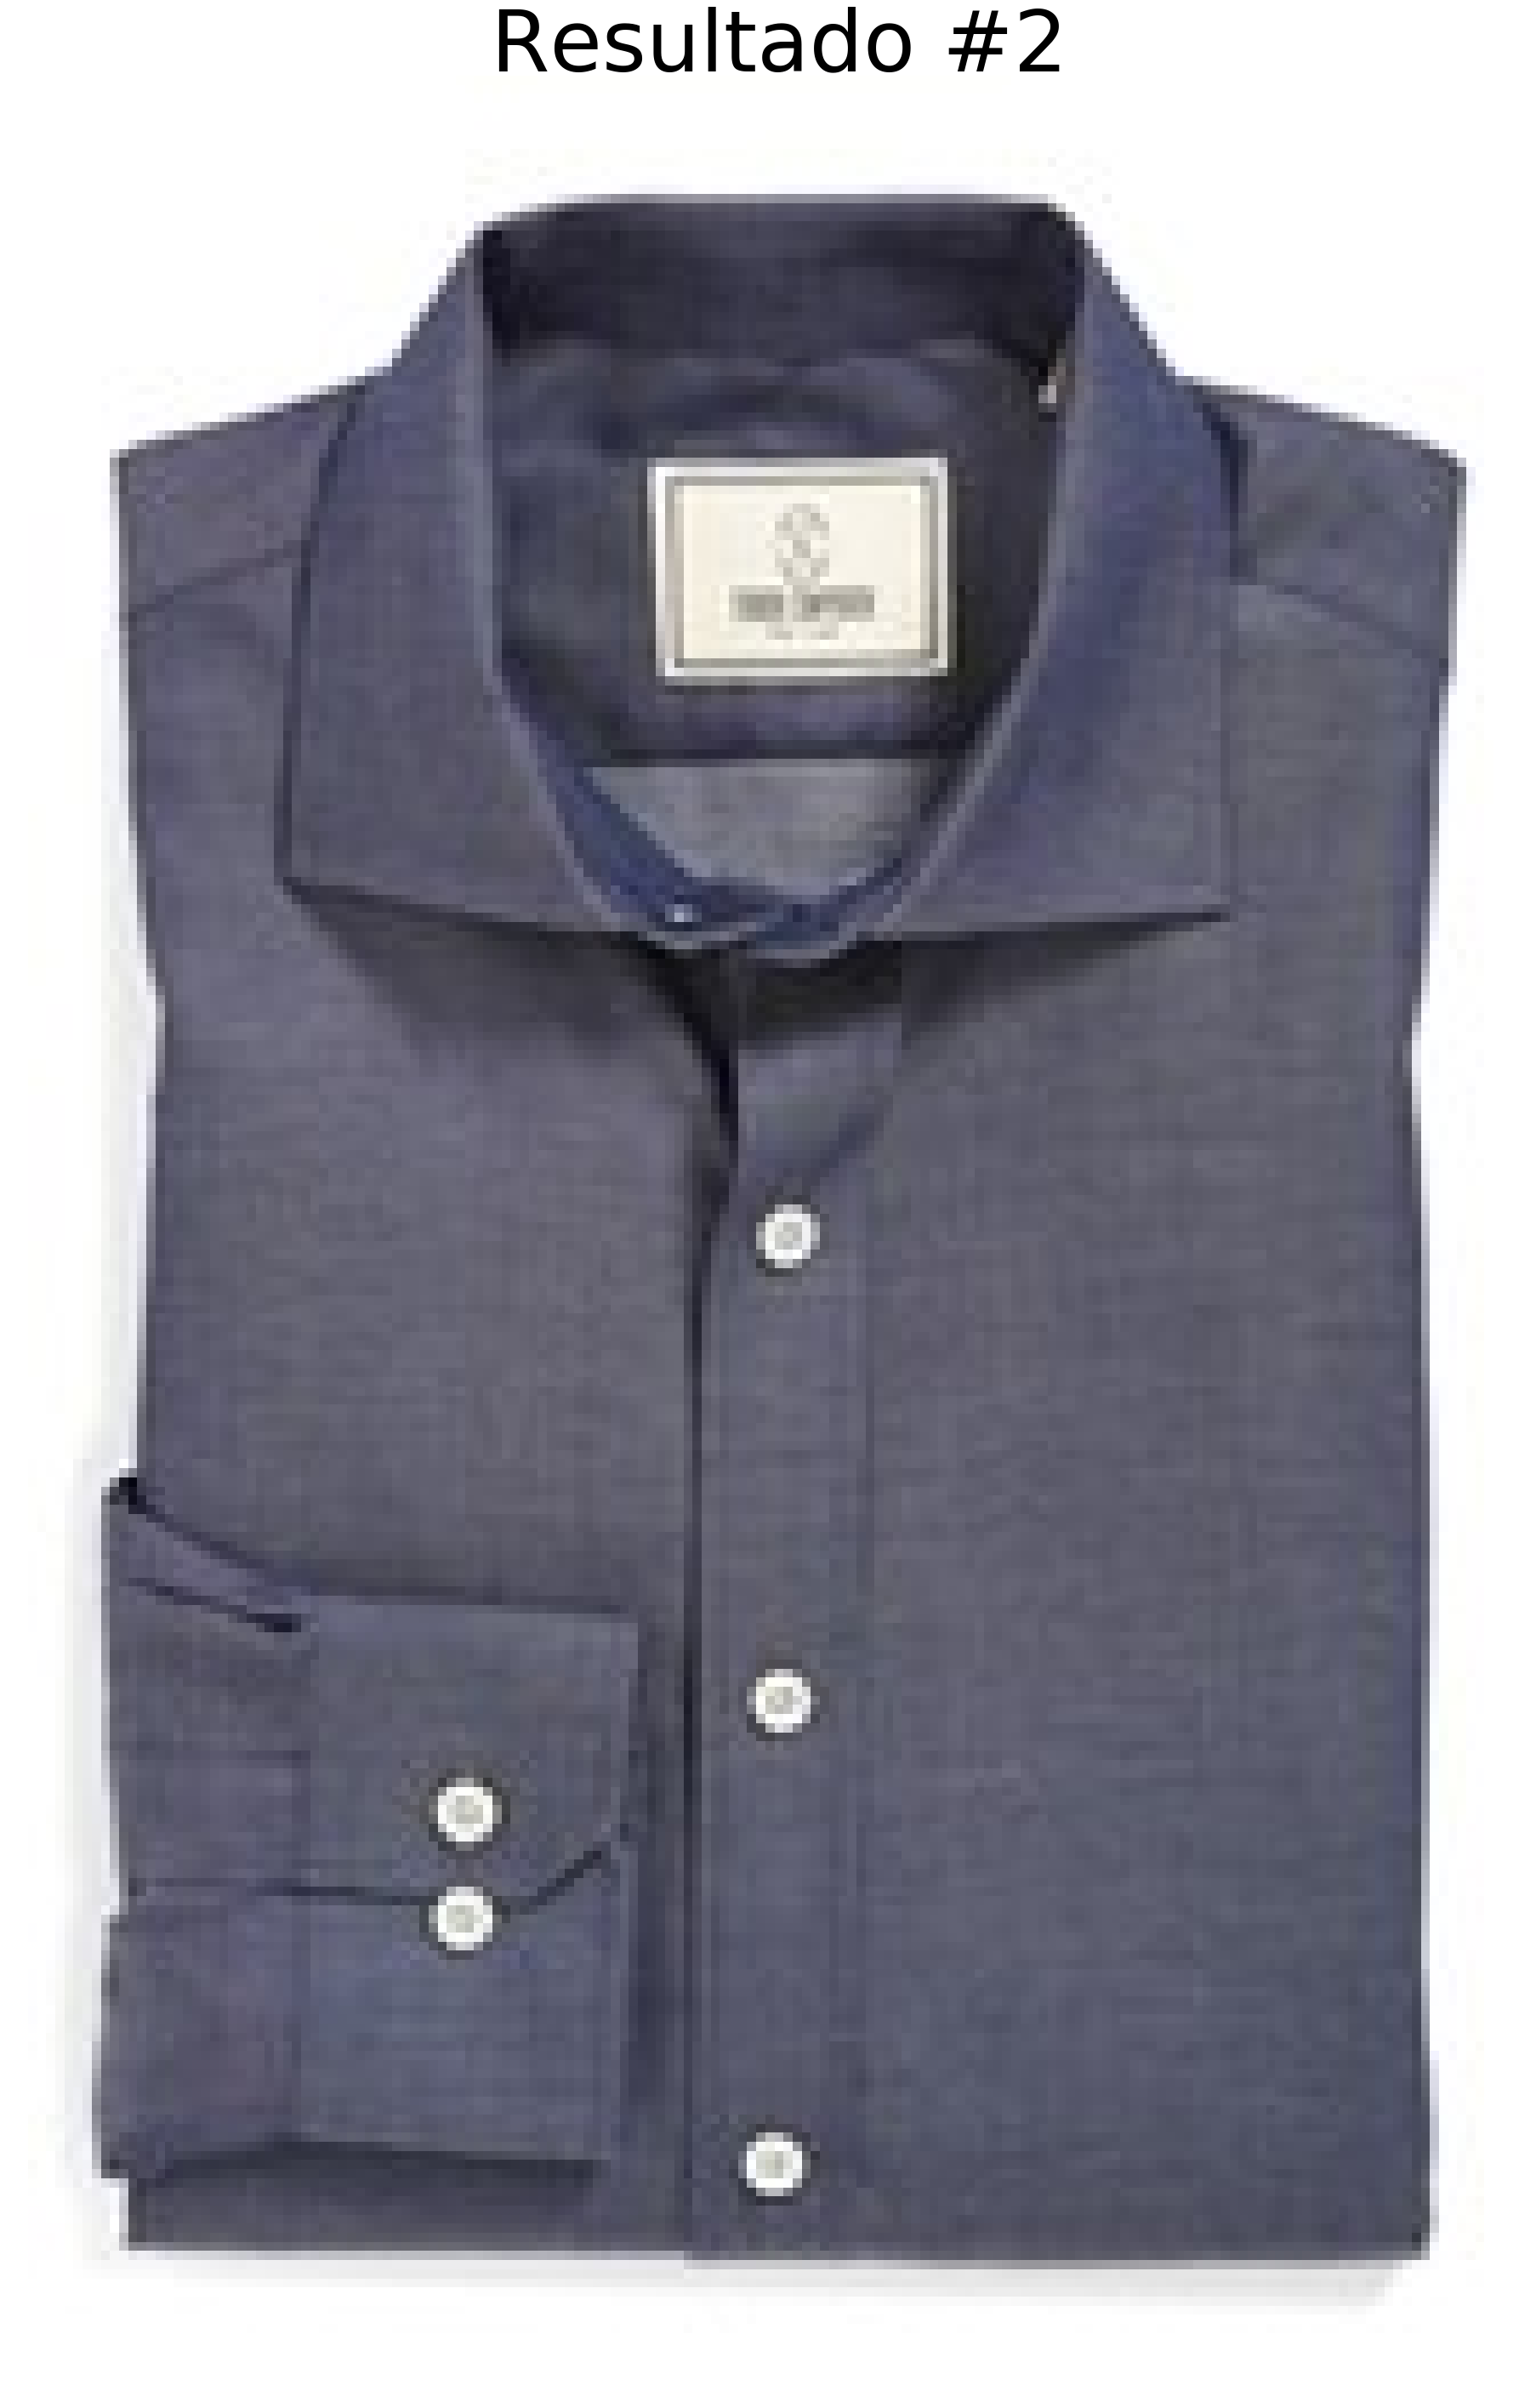

#3. shirt_04.jpg: 0.0153


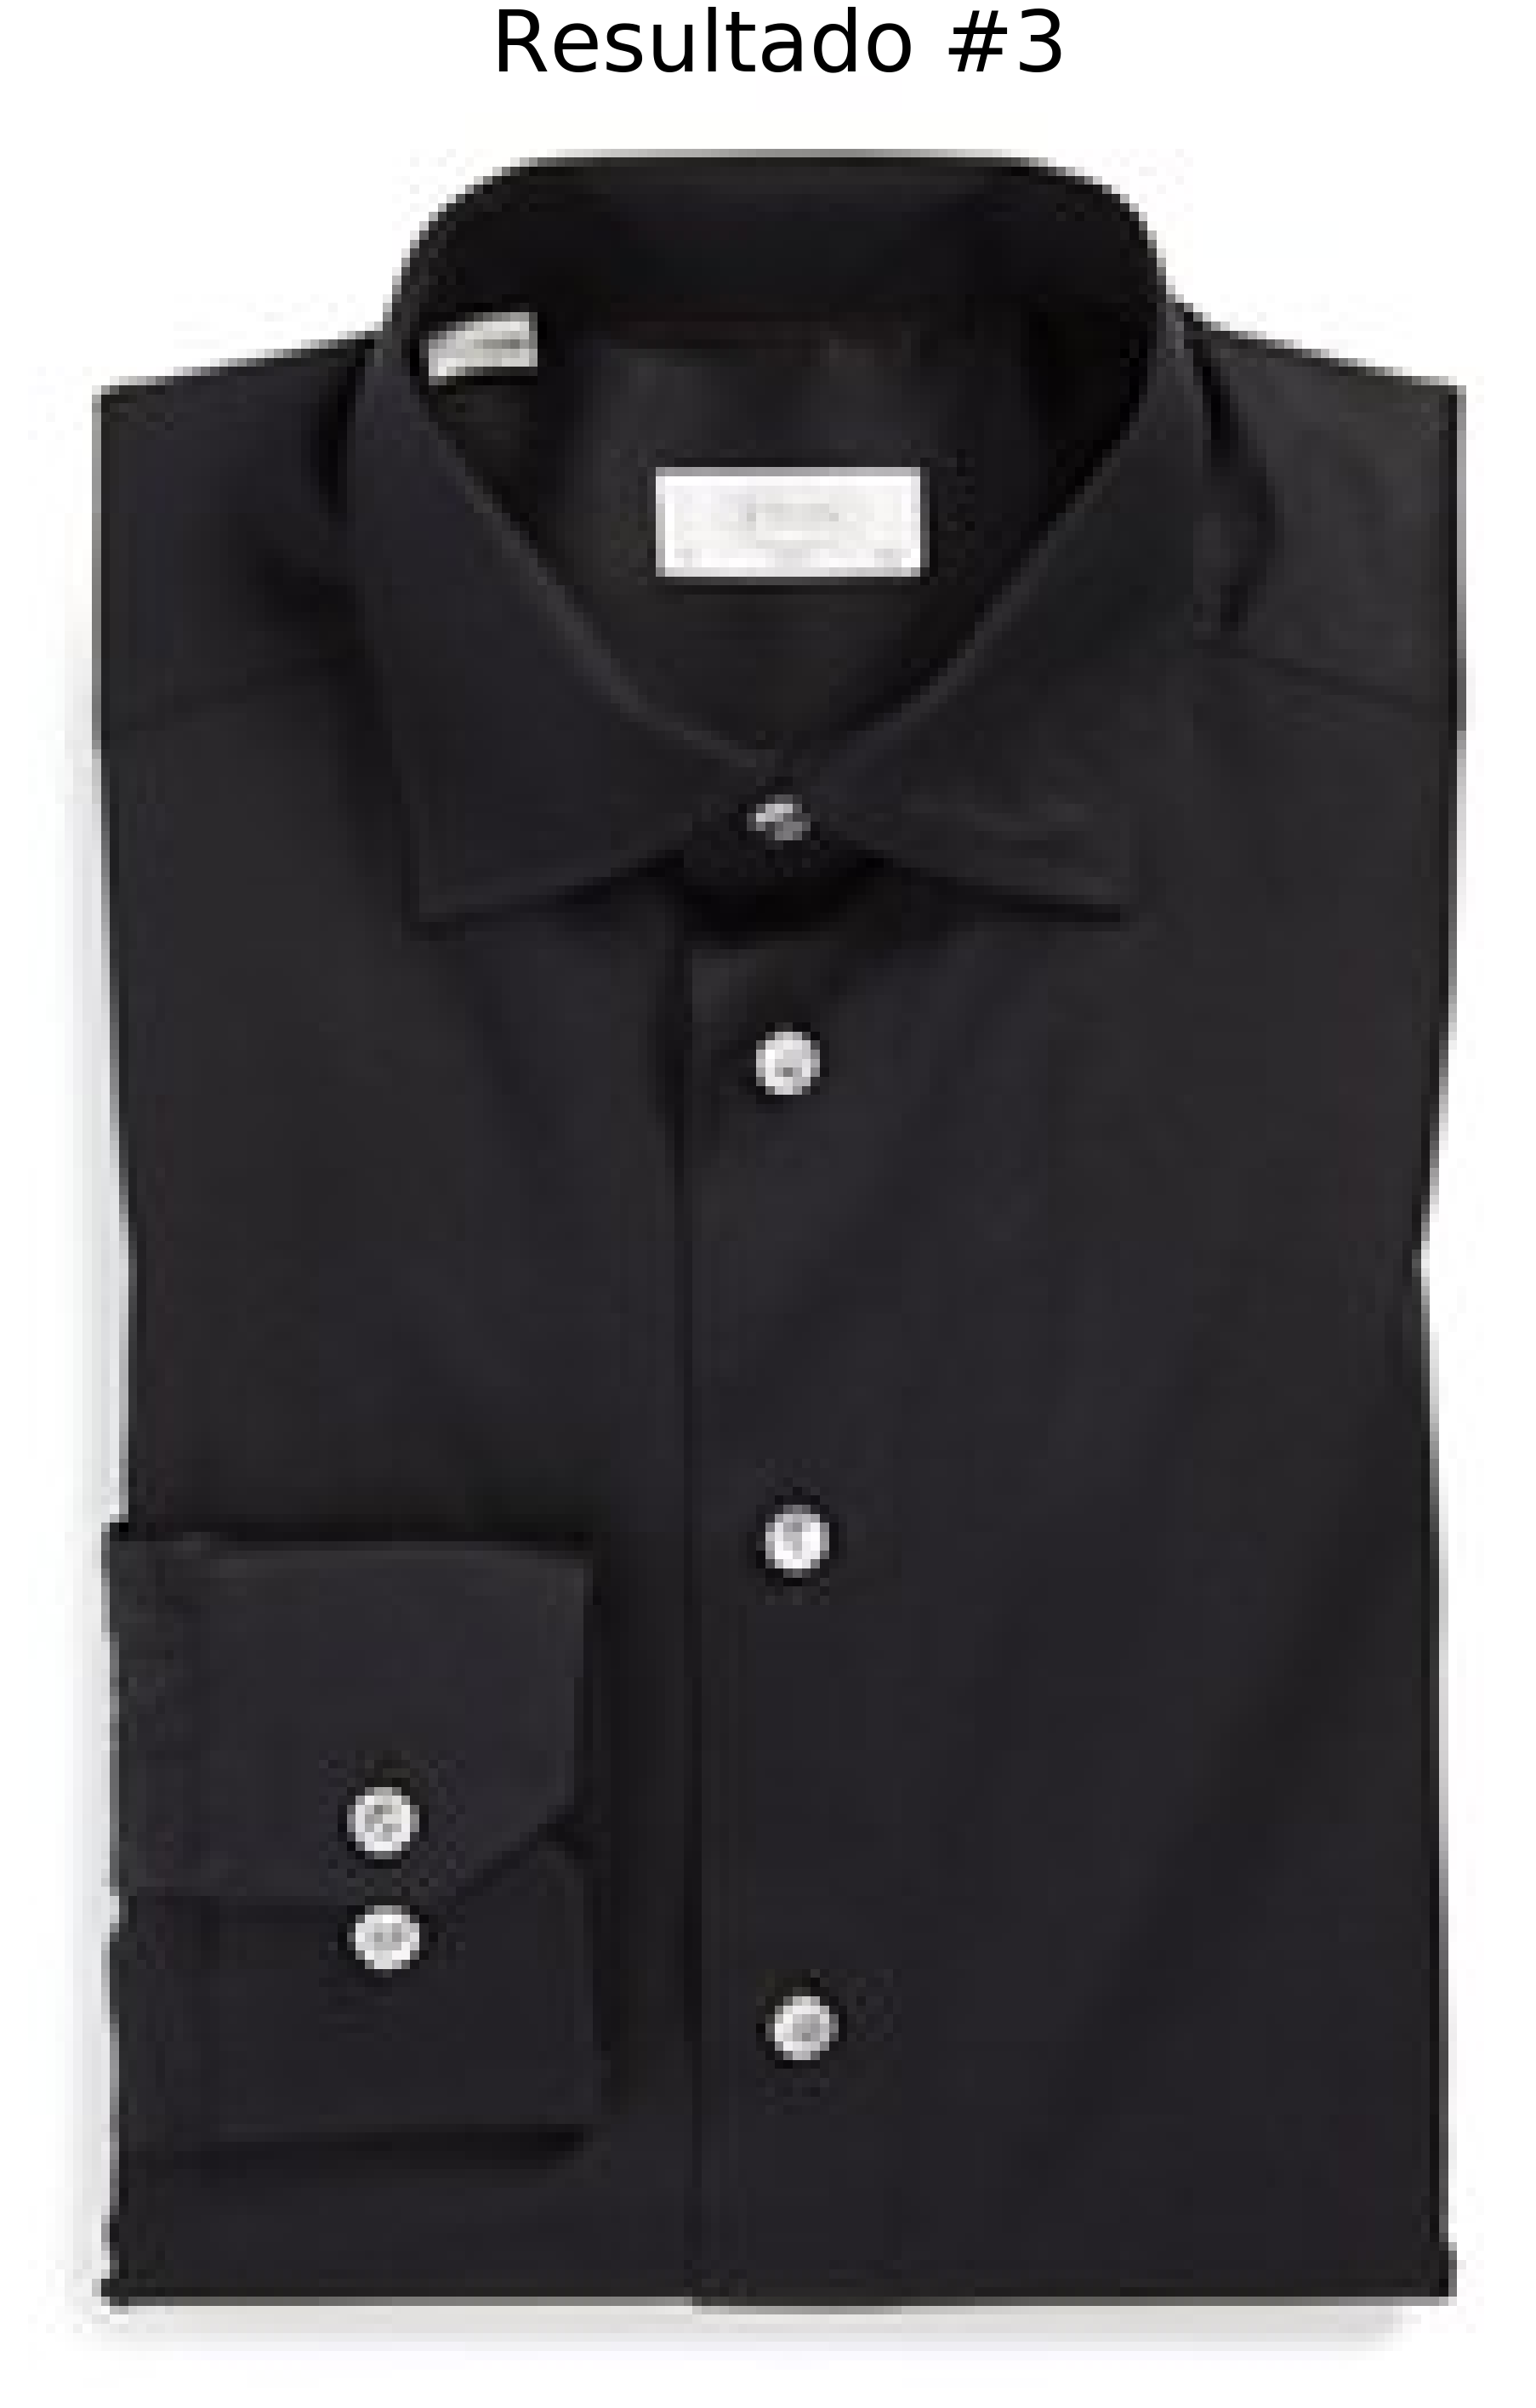

In [9]:
# Loop pelos resultados
for (i, (score, filename)) in enumerate(results):
    print("#%d. %s: %.4f" % (i + 1, filename, score))
    image = cv2.imread("imagens/dataset03/shirts" + "/" + filename)
    show(image, "Resultado #{}".format(i + 1))